In [1]:
!pip install pymongo
!pip install sklearn
!pip install seaborn
!pip install matplotlib

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pymongo

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score


In [3]:
client = pymongo.MongoClient('mongo', 27017)

# Database Name conection
db = client["movies_database"]

# Collection Name
col = db["data"]
x = col.find()

df =  pd.DataFrame(list(x))

In [4]:
#df = pd.read_csv('./../../app/services/node-red/files/movies_list_2012-2020.csv')

In [5]:
df_results = pd.DataFrame(columns=['algorithm_name', 'score', 'target'])

In [6]:
df.head()

,_id,movie_title,gross_total,max_theaters,opening_weekend_gross,release_date,score,running_time_min,production_budget,genre_action,...,genre_horror,genre_kids,genre_musical,genre_mystery,genre_romance,genre_sci-fi,genre_tv_series,genre_thriller,genre_war,genre_western
0,6290f4ecb39c6500123b14d1,The Avengers,623357910,4349,207438708,2012/05/4,3.0,89,225000000,1,...,0,0,0,0,0,1,0,0,0,0
1,6290f4ecb39c6500123b14d2,The Dark Knight Rises,448139099,4404,160887295,2012/07/20,7.5,164,230000000,1,...,0,0,0,0,0,0,0,1,0,0
2,6290f4ecb39c6500123b14d3,The Hunger Games,408010692,4137,152535747,2012/03/23,6.2,143,80000000,0,...,0,0,0,0,0,1,0,1,0,0
3,6290f4ecb39c6500123b14d4,Skyfall,304360277,3526,88364714,2012/11/9,6.6,143,200000000,1,...,0,0,0,0,0,0,0,1,0,0
4,6290f4ecb39c6500123b14d5,The Hobbit: An Unexpected Journey,303003568,4100,84617303,2012/12/14,7.0,170,200000000,1,...,0,0,0,0,0,0,0,0,0,0


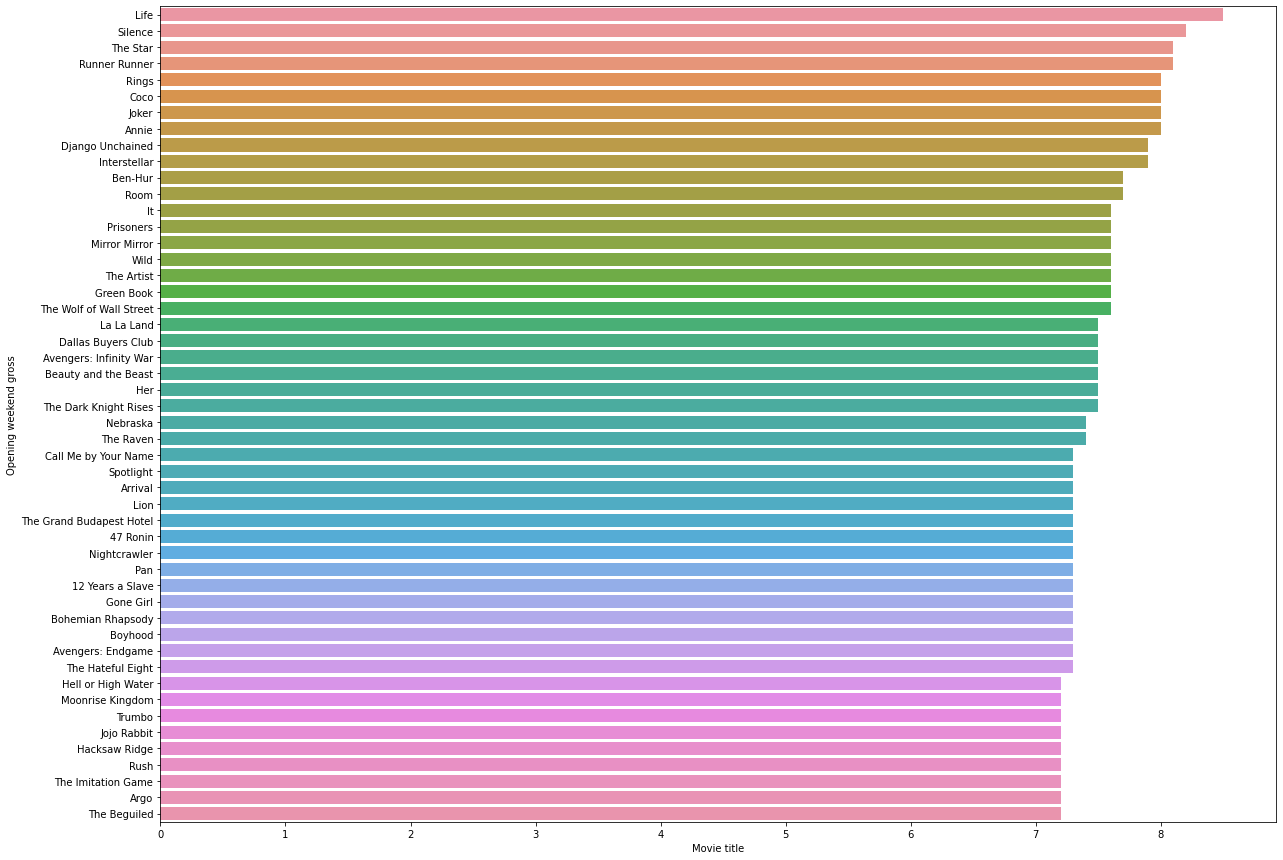

In [7]:
# TOP 50 movies opening weekend
top_movies_opening_weekend = df[["movie_title", "score"]].sort_values(by="score", ascending=False)
top_movies_opening_weekend[:50]

plt.figure(figsize=(20, 15))
sns.barplot(
    y = "movie_title",
    x = "score",
    data = top_movies_opening_weekend[:50]
)
plt.ylabel("Opening weekend gross")
plt.xlabel("Movie title")

plt.show()

# Pre-analysis

In [8]:
df = df.drop(columns=['_id'], axis=0)
original_df = df
df = df.drop(columns=['release_date', 'movie_title'], axis=0)

## Differents values

In [9]:
df['max_theaters'].describe()

count     947.000000
mean     2818.786695
std       971.671773
min       600.000000
25%      2233.000000
50%      3003.000000
75%      3517.000000
max      4802.000000
Name: max_theaters, dtype: float64

In [10]:
df['score'].describe()

count    947.000000
mean       5.605385
std        0.981683
min        2.500000
25%        4.900000
50%        5.600000
75%        6.300000
max        8.500000
Name: score, dtype: float64

In [11]:
df['running_time_min'].describe()

count    947.000000
mean     109.280887
std       19.235364
min        4.000000
25%       96.000000
50%      107.000000
75%      121.000000
max      207.000000
Name: running_time_min, dtype: float64

In [12]:
for col in df.columns.to_list():
  if col.startswith('genre_'):
    print(f'{col}: {df[col].value_counts()[1]}/{len(df)}')

genre_action: 251/947
genre_adventure: 144/947
genre_animation: 83/947
genre_comedy: 330/947
genre_documentary: 6/947
genre_drama: 325/947
genre_fantasy: 150/947
genre_film_noir: 5/947
genre_horror: 107/947
genre_kids: 28/947
genre_musical: 20/947
genre_mystery: 46/947
genre_romance: 95/947
genre_sci-fi: 139/947
genre_tv_series: 3/947
genre_thriller: 215/947
genre_war: 22/947
genre_western: 9/947


## Outliers

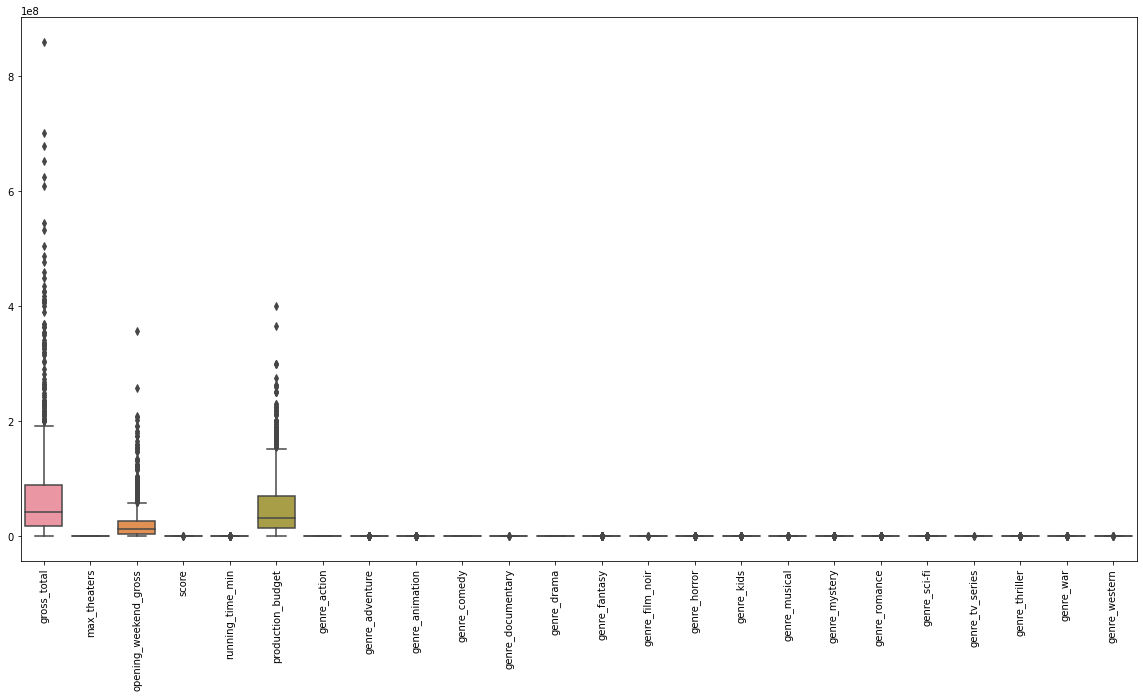

In [13]:
plt.figure(figsize=(20, 10))
ax = sns.boxplot(data=df)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## Correlation

In [14]:
df.head()

,gross_total,max_theaters,opening_weekend_gross,score,running_time_min,production_budget,genre_action,genre_adventure,genre_animation,genre_comedy,...,genre_horror,genre_kids,genre_musical,genre_mystery,genre_romance,genre_sci-fi,genre_tv_series,genre_thriller,genre_war,genre_western
0,623357910,4349,207438708,3.0,89,225000000,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,448139099,4404,160887295,7.5,164,230000000,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,408010692,4137,152535747,6.2,143,80000000,0,1,0,0,...,0,0,0,0,0,1,0,1,0,0
3,304360277,3526,88364714,6.6,143,200000000,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,303003568,4100,84617303,7.0,170,200000000,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


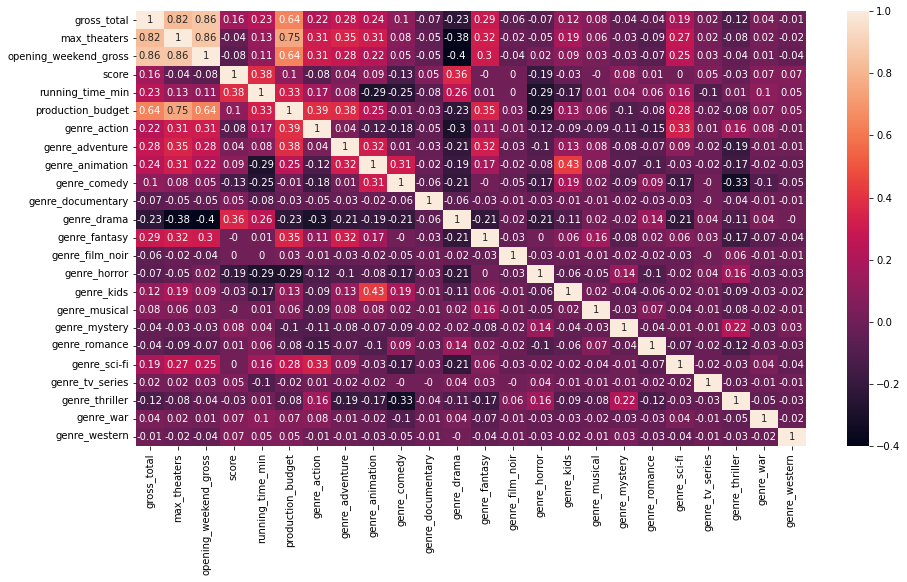

In [15]:
plt.figure(figsize=(15, 8))
sns.heatmap(round(df.corr(method='spearman'), 2), annot=True, mask=None)
plt.show()

# Models

1. Predict Score (without total gross)
2. Total gross (without score)
3. Opening weekend gross (without total gross and score)

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
def prediccion(y_test,y_pred):
  validos=0
  no_validos=0
  for i in range(len(y_pred)):
    if y_test.iloc[i]==y_pred[i].astype(int):
      validos=validos+1
    else:
      no_validos=no_validos+1
  return(print("Validos: ",validos," / No validos: ",no_validos))

## 1. Predict Score

In [18]:
cols = list(df.columns)
scaler = MinMaxScaler()

df_regresion = df.drop(columns=['score', 'gross_total'])
X = df_regresion
y = pd.DataFrame(df['score'].values.tolist(), columns=['score'])

X = scaler.fit_transform(X)
y = df['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Linear Regression

In [19]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [20]:
score = model.score(X_test, y_test)
print(score)

0.33397603327373815


In [21]:
y_pred = model.predict(X_test)
r2 = r2_score(y_test,y_pred)
df_results = df_results.append({'algorithm_name':'linear_regression', 'score': r2, 'target': 'score'}, ignore_index=True)

results = pd.DataFrame(columns=['movie_title', 'score', 'predicted_score'])
results['movie_title']=original_df['movie_title']
results['score']=original_df['score']
results['predicted_score']=model.predict(X)

results.head()

/tmp/ipykernel_809/1465801763.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({'algorithm_name':'linear_regression', 'score': r2, 'target': 'score'}, ignore_index=True)


,movie_title,score,predicted_score
0,The Avengers,3.0,5.572394
1,The Dark Knight Rises,7.5,7.275642
2,The Hunger Games,6.2,6.239320
3,Skyfall,6.6,6.110336
4,The Hobbit: An Unexpected Journey,7.0,6.397499


#### Lasso

In [22]:
from sklearn.linear_model import Lasso

model = Lasso()
model.fit(X_train, y_train)

Lasso()

In [23]:
score = model.score(X_test, y_test)
print(score)

-0.0025262579031806176


In [24]:
y_pred = model.predict(X_test)
r2 = r2_score(y_test,y_pred)
df_results = df_results.append({'algorithm_name':'lasso', 'score': r2, 'target': 'score'}, ignore_index=True)

results = pd.DataFrame(columns=['movie_title', 'score', 'predicted_score'])
results['movie_title']=original_df['movie_title']
results['score']=original_df['score']
results['predicted_score']=model.predict(X)

results.head()

/tmp/ipykernel_809/334102726.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({'algorithm_name':'lasso', 'score': r2, 'target': 'score'}, ignore_index=True)


,movie_title,score,predicted_score
0,The Avengers,3.0,5.596169
1,The Dark Knight Rises,7.5,5.596169
2,The Hunger Games,6.2,5.596169
3,Skyfall,6.6,5.596169
4,The Hobbit: An Unexpected Journey,7.0,5.596169


#### SGDRegressor

In [25]:
from sklearn.linear_model import SGDRegressor

model = SGDRegressor()
model.fit(X_train, y_train)

SGDRegressor()

In [26]:
score = model.score(X_test, y_test)
print(score)

0.23975844518145306


In [27]:
y_pred = model.predict(X_test)
r2 = r2_score(y_test,y_pred)
df_results = df_results.append({'algorithm_name':'sgd_regressor', 'score': r2, 'target': 'score'}, ignore_index=True)

results = pd.DataFrame(columns=['movie_title', 'score', 'predicted_score'])
results['movie_title']=original_df['movie_title']
results['score']=original_df['score']
results['predicted_score']=model.predict(X)

results.head()

/tmp/ipykernel_809/1410548313.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({'algorithm_name':'sgd_regressor', 'score': r2, 'target': 'score'}, ignore_index=True)


,movie_title,score,predicted_score
0,The Avengers,3.0,5.335642
1,The Dark Knight Rises,7.5,7.182388
2,The Hunger Games,6.2,6.058797
3,Skyfall,6.6,5.831571
4,The Hobbit: An Unexpected Journey,7.0,6.183505


#### SVR

##### Linear

In [28]:
from sklearn import svm

model = svm.SVR(kernel='linear')
model.fit(X_train, y_train)

SVR(kernel='linear')

In [29]:
score = model.score(X_test, y_test)
print(score)

0.33732548630737846


In [30]:
y_pred = model.predict(X_test)
r2 = r2_score(y_test,y_pred)
df_results = df_results.append({'algorithm_name':'svr_linear', 'score': r2, 'target': 'score'}, ignore_index=True)

results = pd.DataFrame(columns=['movie_title', 'score', 'predicted_score'])
results['movie_title']=original_df['movie_title']
results['score']=original_df['score']
results['predicted_score']=model.predict(X)

results.head()

/tmp/ipykernel_809/2859717847.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({'algorithm_name':'svr_linear', 'score': r2, 'target': 'score'}, ignore_index=True)


,movie_title,score,predicted_score
0,The Avengers,3.0,5.483498
1,The Dark Knight Rises,7.5,7.223675
2,The Hunger Games,6.2,6.099851
3,Skyfall,6.6,6.104844
4,The Hobbit: An Unexpected Journey,7.0,6.268457


##### RBF

In [31]:
from sklearn import svm

model = svm.SVR(kernel='rbf')
model.fit(X_train, y_train)

SVR()

In [32]:
score = model.score(X_test, y_test)
print(score)

0.3525091645655023


In [33]:
y_pred = model.predict(X_test)
r2 = r2_score(y_test,y_pred)
df_results = df_results.append({'algorithm_name':'svr_rbf', 'score': r2, 'target': 'score'}, ignore_index=True)

results = pd.DataFrame(columns=['movie_title', 'score', 'predicted_score'])
results['movie_title']=original_df['movie_title']
results['score']=original_df['score']
results['predicted_score']=model.predict(X)

results.head()

/tmp/ipykernel_809/1552659799.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({'algorithm_name':'svr_rbf', 'score': r2, 'target': 'score'}, ignore_index=True)


,movie_title,score,predicted_score
0,The Avengers,3.0,5.536473
1,The Dark Knight Rises,7.5,6.902948
2,The Hunger Games,6.2,6.100382
3,Skyfall,6.6,5.936162
4,The Hobbit: An Unexpected Journey,7.0,5.919995


#### Ridge Regression

In [34]:
from sklearn.linear_model import Ridge

model = Ridge()
model.fit(X_train, y_train)

Ridge()

In [35]:
score = model.score(X_test, y_test)
print(score)

0.32665458304433537


In [36]:
y_pred = model.predict(X_test)
r2 = r2_score(y_test,y_pred)
df_results = df_results.append({'algorithm_name':'ridge_regression', 'score': r2, 'target': 'score'}, ignore_index=True)

results = pd.DataFrame(columns=['movie_title', 'score', 'predicted_score'])
results['movie_title']=original_df['movie_title']
results['score']=original_df['score']
results['predicted_score']=model.predict(X)

results.head()

/tmp/ipykernel_809/2180254232.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({'algorithm_name':'ridge_regression', 'score': r2, 'target': 'score'}, ignore_index=True)


,movie_title,score,predicted_score
0,The Avengers,3.0,5.613122
1,The Dark Knight Rises,7.5,7.134857
2,The Hunger Games,6.2,6.089005
3,Skyfall,6.6,6.036784
4,The Hobbit: An Unexpected Journey,7.0,6.273254


#### Random Forest Regressor

In [37]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=700) 
model.fit(X_train, y_train)
y_pred = model.predict(X_test) 


In [38]:
score = model.score(X_test, y_test)
print(score)

0.4332294227703821


In [39]:
y_pred = model.predict(X_test)
r2 = r2_score(y_test,y_pred)
df_results = df_results.append({'algorithm_name':'random_forest_regressor', 'score': r2, 'target': 'score'}, ignore_index=True)

results = pd.DataFrame(columns=['movie_title', 'score', 'predicted_score'])
results['movie_title']=original_df['movie_title']
results['score']=original_df['score']
results['predicted_score']=model.predict(X)

results.head()

/tmp/ipykernel_809/2918771794.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({'algorithm_name':'random_forest_regressor', 'score': r2, 'target': 'score'}, ignore_index=True)


,movie_title,score,predicted_score
0,The Avengers,3.0,4.193714
1,The Dark Knight Rises,7.5,7.140286
2,The Hunger Games,6.2,6.259286
3,Skyfall,6.6,6.454000
4,The Hobbit: An Unexpected Journey,7.0,6.924571


## 2. Gross total

In [40]:
from sklearn.preprocessing import MinMaxScaler

cols = list(df.columns)
scaler = MinMaxScaler()

df = scaler.fit_transform(df)
df = pd.DataFrame(df, columns=cols)

df_regresion = df.drop(columns=['score', 'gross_total', 'max_theaters'])
X = df_regresion
y = df['gross_total']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Linear Regression

In [41]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [42]:
score = model.score(X_test, y_test)
print(score)

0.8328781399862263


In [43]:
y_pred = model.predict(X_test)
r2 = r2_score(y_test,y_pred)
df_results = df_results.append({'algorithm_name':'linear_regression', 'score': r2, 'target': 'gross_total'}, ignore_index=True)

results = pd.DataFrame(columns=['movie_title', 'gross_total', 'predicted_gross_total'])
results['movie_title']=original_df['movie_title']
results['gross_total']=original_df['gross_total']
results['predicted_gross_total']=model.predict(X)

results.head()

/tmp/ipykernel_809/1779599361.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({'algorithm_name':'linear_regression', 'score': r2, 'target': 'gross_total'}, ignore_index=True)


,movie_title,gross_total,predicted_gross_total
0,The Avengers,623357910,0.643438
1,The Dark Knight Rises,448139099,0.546299
2,The Hunger Games,408010692,0.481233
3,Skyfall,304360277,0.300297
4,The Hobbit: An Unexpected Journey,303003568,0.300426


#### Lasso

In [44]:
from sklearn.linear_model import Lasso

model = Lasso()
model.fit(X_train, y_train)

Lasso()

In [45]:
score = model.score(X_test, y_test)
print(score)

-0.028736115759946168


In [46]:
y_pred = model.predict(X_test)
r2 = r2_score(y_test,y_pred)
df_results = df_results.append({'algorithm_name':'lasso', 'score': r2, 'target': 'gross_total'}, ignore_index=True)

results = pd.DataFrame(columns=['movie_title', 'gross_total', 'predicted_gross_total'])
results['movie_title']=original_df['movie_title']
results['gross_total']=original_df['gross_total']
results['predicted_gross_total']=model.predict(X)

results.head()

/tmp/ipykernel_809/2478931677.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({'algorithm_name':'lasso', 'score': r2, 'target': 'gross_total'}, ignore_index=True)


,movie_title,gross_total,predicted_gross_total
0,The Avengers,623357910,0.091324
1,The Dark Knight Rises,448139099,0.091324
2,The Hunger Games,408010692,0.091324
3,Skyfall,304360277,0.091324
4,The Hobbit: An Unexpected Journey,303003568,0.091324


#### SGDRegressor

In [47]:
from sklearn.linear_model import SGDRegressor

model = SGDRegressor()
model.fit(X_train, y_train)

SGDRegressor()

In [48]:
score = model.score(X_test, y_test)
print(score)

0.2592452516248632


In [49]:
y_pred = model.predict(X_test)
r2 = r2_score(y_test,y_pred)
df_results = df_results.append({'algorithm_name':'sgd_regressor', 'score': r2, 'target': 'gross_total'}, ignore_index=True)

results = pd.DataFrame(columns=['movie_title', 'gross_total', 'predicted_gross_total'])
results['movie_title']=original_df['movie_title']
results['gross_total']=original_df['gross_total']
results['predicted_gross_total']=model.predict(X)

results.head()

/tmp/ipykernel_809/1307650729.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({'algorithm_name':'sgd_regressor', 'score': r2, 'target': 'gross_total'}, ignore_index=True)


,movie_title,gross_total,predicted_gross_total
0,The Avengers,623357910,0.202607
1,The Dark Knight Rises,448139099,0.155303
2,The Hunger Games,408010692,0.159991
3,Skyfall,304360277,0.137099
4,The Hobbit: An Unexpected Journey,303003568,0.246523


#### SVR

##### Linear

In [50]:
from sklearn import svm

model = svm.SVR(kernel='linear')
model.fit(X_train, y_train)

SVR(kernel='linear')

In [51]:
score = model.score(X_test, y_test)
print(score)

0.39692157823737395


In [52]:
y_pred = model.predict(X_test)
prediccion(y_test,y_pred)
r2 = r2_score(y_test,y_pred)
df_results = df_results.append({'algorithm_name':'svr_linear', 'score': r2, 'target': 'gross_total'}, ignore_index=True)

results = pd.DataFrame(columns=['movie_title', 'gross_total', 'predicted_gross_total'])
results['movie_title']=original_df['movie_title']
results['gross_total']=original_df['gross_total']
results['predicted_gross_total']=model.predict(X)

results.head()

Validos:  0  / No validos:  190


/tmp/ipykernel_809/45443282.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({'algorithm_name':'svr_linear', 'score': r2, 'target': 'gross_total'}, ignore_index=True)


,movie_title,gross_total,predicted_gross_total
0,The Avengers,623357910,0.636593
1,The Dark Knight Rises,448139099,0.533671
2,The Hunger Games,408010692,0.472203
3,Skyfall,304360277,0.337160
4,The Hobbit: An Unexpected Journey,303003568,0.342360


##### RBF

In [53]:
from sklearn import svm

model = svm.SVR(kernel='rbf')
model.fit(X_train, y_train)

SVR()

In [54]:
score = model.score(X_test, y_test)
print(score)

0.2754478709468974


In [55]:
y_pred = model.predict(X_test)
r2 = r2_score(y_test,y_pred)
df_results = df_results.append({'algorithm_name':'svr_rbf', 'score': r2, 'target': 'gross_total'}, ignore_index=True)

results = pd.DataFrame(columns=['movie_title', 'gross_total', 'predicted_gross_total'])
results['movie_title']=original_df['movie_title']
results['gross_total']=original_df['gross_total']
results['predicted_gross_total']=model.predict(X)

results.head()

/tmp/ipykernel_809/3600618239.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({'algorithm_name':'svr_rbf', 'score': r2, 'target': 'gross_total'}, ignore_index=True)


,movie_title,gross_total,predicted_gross_total
0,The Avengers,623357910,0.625772
1,The Dark Knight Rises,448139099,0.421863
2,The Hunger Games,408010692,0.375148
3,Skyfall,304360277,0.280398
4,The Hobbit: An Unexpected Journey,303003568,0.324438


#### Ridge Regression

In [56]:
from sklearn.linear_model import Ridge

model = Ridge()
model.fit(X_train, y_train)

Ridge()

In [57]:
score = model.score(X_test, y_test)
print(score)

0.8052019303459254


In [58]:
y_pred = model.predict(X_test)
r2 = r2_score(y_test,y_pred)
df_results = df_results.append({'algorithm_name':'ridge_regression', 'score': r2, 'target': 'gross_total'}, ignore_index=True)

results = pd.DataFrame(columns=['movie_title', 'gross_total', 'predicted_gross_total'])
results['movie_title']=original_df['movie_title']
results['gross_total']=original_df['gross_total']
results['predicted_gross_total']=model.predict(X)

results.head()

/tmp/ipykernel_809/3056617725.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({'algorithm_name':'ridge_regression', 'score': r2, 'target': 'gross_total'}, ignore_index=True)


,movie_title,gross_total,predicted_gross_total
0,The Avengers,623357910,0.566478
1,The Dark Knight Rises,448139099,0.495023
2,The Hunger Games,408010692,0.402409
3,Skyfall,304360277,0.290953
4,The Hobbit: An Unexpected Journey,303003568,0.298203


#### Random Forest Regressor

In [59]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=700) 
model.fit(X_train, y_train)
y_pred = model.predict(X_test) 


In [60]:
score = model.score(X_test, y_test)
print(score)

0.8235974067857588


In [61]:
y_pred = model.predict(X_test)
r2 = r2_score(y_test,y_pred)
df_results = df_results.append({'algorithm_name':'random_forest_regressor', 'score': r2, 'target': 'gross_total'}, ignore_index=True)

results = pd.DataFrame(columns=['movie_title', 'gross_total', 'predicted_gross_total'])
results['movie_title']=original_df['movie_title']
results['gross_total']=original_df['gross_total']
results['predicted_gross_total']=model.predict(X)

results.head()

/tmp/ipykernel_809/1198342763.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({'algorithm_name':'random_forest_regressor', 'score': r2, 'target': 'gross_total'}, ignore_index=True)


,movie_title,gross_total,predicted_gross_total
0,The Avengers,623357910,0.732518
1,The Dark Knight Rises,448139099,0.498127
2,The Hunger Games,408010692,0.478228
3,Skyfall,304360277,0.324378
4,The Hobbit: An Unexpected Journey,303003568,0.327212


## 3. Opening weekend gross

In [62]:
from sklearn.preprocessing import MinMaxScaler

cols = list(df.columns)
scaler = MinMaxScaler()

df = scaler.fit_transform(df)
df = pd.DataFrame(df, columns=cols)

df_regresion = df.drop(columns=['opening_weekend_gross','score', 'gross_total'])
X = df_regresion
y = df['opening_weekend_gross']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Linear Regression

In [63]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [64]:
score = model.score(X_test, y_test)
print(score)

0.5226359115527632


In [65]:
y_pred = model.predict(X_test)
r2 = r2_score(y_test,y_pred)
df_results = df_results.append({'algorithm_name':'linear_regression', 'score': r2, 'target': 'opening_weekend_gross'}, ignore_index=True)

results = pd.DataFrame(columns=['movie_title', 'opening_weekend_gross', 'predicted_opening_weekend_gross'])
results['movie_title']=original_df['movie_title']
results['opening_weekend_gross']=original_df['opening_weekend_gross']
results['predicted_opening_weekend_gross']=model.predict(X)

results.head()

/tmp/ipykernel_809/1242545313.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({'algorithm_name':'linear_regression', 'score': r2, 'target': 'opening_weekend_gross'}, ignore_index=True)


,movie_title,opening_weekend_gross,predicted_opening_weekend_gross
0,The Avengers,207438708,0.257732
1,The Dark Knight Rises,160887295,0.265067
2,The Hunger Games,152535747,0.113457
3,Skyfall,88364714,0.213228
4,The Hobbit: An Unexpected Journey,84617303,0.234198


#### Lasso

In [66]:
from sklearn.linear_model import Lasso

model = Lasso()
model.fit(X_train, y_train)

Lasso()

In [67]:
score = model.score(X_test, y_test)
print(score)

-0.023538630940590277


In [68]:
y_pred = model.predict(X_test)
r2 = r2_score(y_test,y_pred)
df_results = df_results.append({'algorithm_name':'lasso', 'score': r2, 'target': 'opening_weekend_gross'}, ignore_index=True)

results = pd.DataFrame(columns=['movie_title', 'opening_weekend_gross', 'predicted_opening_weekend_gross'])
results['movie_title']=original_df['movie_title']
results['opening_weekend_gross']=original_df['opening_weekend_gross']
results['predicted_opening_weekend_gross']=model.predict(X)

results.head()

/tmp/ipykernel_809/3202324933.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({'algorithm_name':'lasso', 'score': r2, 'target': 'opening_weekend_gross'}, ignore_index=True)


,movie_title,opening_weekend_gross,predicted_opening_weekend_gross
0,The Avengers,207438708,0.066943
1,The Dark Knight Rises,160887295,0.066943
2,The Hunger Games,152535747,0.066943
3,Skyfall,88364714,0.066943
4,The Hobbit: An Unexpected Journey,84617303,0.066943


#### SGDRegressor

In [69]:
from sklearn.linear_model import SGDRegressor

model = SGDRegressor()
model.fit(X_train, y_train)

SGDRegressor()

In [70]:
score = model.score(X_test, y_test)
print(score)

0.28181453126166245


In [71]:
y_pred = model.predict(X_test)
r2 = r2_score(y_test,y_pred)
df_results = df_results.append({'algorithm_name':'sgd_regressor', 'score': r2, 'target': 'opening_weekend_gross'}, ignore_index=True)

results = pd.DataFrame(columns=['movie_title', 'opening_weekend_gross', 'predicted_opening_weekend_gross'])
results['movie_title']=original_df['movie_title']
results['opening_weekend_gross']=original_df['opening_weekend_gross']
results['predicted_opening_weekend_gross']=model.predict(X)

results.head()

/tmp/ipykernel_809/757275296.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({'algorithm_name':'sgd_regressor', 'score': r2, 'target': 'opening_weekend_gross'}, ignore_index=True)


,movie_title,opening_weekend_gross,predicted_opening_weekend_gross
0,The Avengers,207438708,0.161095
1,The Dark Knight Rises,160887295,0.111981
2,The Hunger Games,152535747,0.123547
3,Skyfall,88364714,0.109324
4,The Hobbit: An Unexpected Journey,84617303,0.192960


#### SVR

##### Linear

In [72]:
from sklearn import svm

model = svm.SVR(kernel='linear')
model.fit(X_train, y_train)

SVR(kernel='linear')

In [73]:
score = model.score(X_test, y_test)
print(score)

0.30641146032794775


In [74]:
y_pred = model.predict(X_test)
prediccion(y_test,y_pred)
r2 = r2_score(y_test,y_pred)
df_results = df_results.append({'algorithm_name':'svr_linear', 'score': r2, 'target': 'opening_weekend_gross'}, ignore_index=True)

results = pd.DataFrame(columns=['movie_title', 'opening_weekend_gross', 'predicted_opening_weekend_gross'])
results['movie_title']=original_df['movie_title']
results['opening_weekend_gross']=original_df['opening_weekend_gross']
results['predicted_opening_weekend_gross']=model.predict(X)

results.head()

/tmp/ipykernel_809/2042036646.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({'algorithm_name':'svr_linear', 'score': r2, 'target': 'opening_weekend_gross'}, ignore_index=True)


Validos:  0  / No validos:  190


,movie_title,opening_weekend_gross,predicted_opening_weekend_gross
0,The Avengers,207438708,0.251145
1,The Dark Knight Rises,160887295,0.290993
2,The Hunger Games,152535747,0.165567
3,Skyfall,88364714,0.196517
4,The Hobbit: An Unexpected Journey,84617303,0.246311


##### RBF

In [75]:
from sklearn import svm

model = svm.SVR(kernel='rbf')
model.fit(X_train, y_train)

SVR()

In [76]:
score = model.score(X_test, y_test)
print(score)

0.2865154594555187


In [77]:
y_pred = model.predict(X_test)
r2 = r2_score(y_test,y_pred)
df_results = df_results.append({'algorithm_name':'svr_rbf', 'score': r2, 'target': 'opening_weekend_gross'}, ignore_index=True)

results = pd.DataFrame(columns=['movie_title', 'opening_weekend_gross', 'predicted_opening_weekend_gross'])
results['movie_title']=original_df['movie_title']
results['opening_weekend_gross']=original_df['opening_weekend_gross']
results['predicted_opening_weekend_gross']=model.predict(X)

results.head()

/tmp/ipykernel_809/3252260576.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({'algorithm_name':'svr_rbf', 'score': r2, 'target': 'opening_weekend_gross'}, ignore_index=True)


,movie_title,opening_weekend_gross,predicted_opening_weekend_gross
0,The Avengers,207438708,0.292366
1,The Dark Knight Rises,160887295,0.350393
2,The Hunger Games,152535747,0.326937
3,Skyfall,88364714,0.232857
4,The Hobbit: An Unexpected Journey,84617303,0.278622


#### Ridge Regression

In [78]:
from sklearn.linear_model import Ridge

model = Ridge()
model.fit(X_train, y_train)

Ridge()

In [79]:
score = model.score(X_test, y_test)
print(score)

0.5182143642759611


In [80]:
y_pred = model.predict(X_test)
r2 = r2_score(y_test,y_pred)
df_results = df_results.append({'algorithm_name':'ridge_regression', 'score': r2, 'target': 'opening_weekend_gross'}, ignore_index=True)

results = pd.DataFrame(columns=['movie_title', 'opening_weekend_gross', 'predicted_opening_weekend_gross'])
results['movie_title']=original_df['movie_title']
results['opening_weekend_gross']=original_df['opening_weekend_gross']
results['predicted_opening_weekend_gross']=model.predict(X)

results.head()

/tmp/ipykernel_809/1663586352.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({'algorithm_name':'ridge_regression', 'score': r2, 'target': 'opening_weekend_gross'}, ignore_index=True)


,movie_title,opening_weekend_gross,predicted_opening_weekend_gross
0,The Avengers,207438708,0.246653
1,The Dark Knight Rises,160887295,0.252339
2,The Hunger Games,152535747,0.118265
3,Skyfall,88364714,0.201344
4,The Hobbit: An Unexpected Journey,84617303,0.232013


#### Random Forest Regressor

In [81]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=700) 
model.fit(X_train, y_train)
y_pred = model.predict(X_test) 


In [82]:
score = model.score(X_test, y_test)
print(score)

0.6993625796664593


In [83]:
y_pred = model.predict(X_test)
r2 = r2_score(y_test,y_pred)
df_results = df_results.append({'algorithm_name':'random_forest_regressor', 'score': r2, 'target': 'opening_weekend_gross'}, ignore_index=True)

results = pd.DataFrame(columns=['movie_title', 'opening_weekend_gross', 'predicted_opening_weekend_gross'])
results['movie_title']=original_df['movie_title']
results['opening_weekend_gross']=original_df['opening_weekend_gross']
results['predicted_opening_weekend_gross']=model.predict(X)

results.head()

/tmp/ipykernel_809/634940490.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({'algorithm_name':'random_forest_regressor', 'score': r2, 'target': 'opening_weekend_gross'}, ignore_index=True)


,movie_title,opening_weekend_gross,predicted_opening_weekend_gross
0,The Avengers,207438708,0.500085
1,The Dark Knight Rises,160887295,0.445666
2,The Hunger Games,152535747,0.324789
3,Skyfall,88364714,0.194665
4,The Hobbit: An Unexpected Journey,84617303,0.270454


# Results

In [84]:
df_results['score'] = df_results['score']*100
df_results = df_results.sort_values(by=['score'], ascending=False)

df_score = df_results.loc[df_results['target'] == 'score']
df_gross_total = df_results.loc[df_results['target'] == 'gross_total']
df_opening_weekend_gross = df_results.loc[df_results['target'] == 'opening_weekend_gross']

In [85]:
df_final_results = df_score.head(1)
df_final_results = df_final_results.append(df_gross_total.head(1))
df_final_results = df_final_results.append(df_opening_weekend_gross.head(1))

/tmp/ipykernel_809/2003420596.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final_results = df_final_results.append(df_gross_total.head(1))
/tmp/ipykernel_809/2003420596.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final_results = df_final_results.append(df_opening_weekend_gross.head(1))


## Final conclusion

In [86]:
df_final_results

,algorithm_name,score,target
6,random_forest_regressor,43.322942,score
7,linear_regression,83.287814,gross_total
20,random_forest_regressor,69.936258,opening_weekend_gross
